In [1]:
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import os
import csv
import random
import numpy as np

import time
 
from tqdm import tqdm 

from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold

from tensorflow.keras import backend as K

2025-03-22 11:46:29.077251: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-22 11:46:29.077296: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-22 11:46:29.078017: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 11:46:29.082843: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 11:46:29.589548: W tensorflow/compiler/tf2

In [2]:
num_classes = 1
k = 5


IMG_WIDTH = 512
IMG_HEIGHT = 512
IMG_CHANNELS = 1

DATA_PATH = 'data/'

data_ids = next(os.walk(DATA_PATH+'/image'))[2]

X = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
y = np.zeros((len(data_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

# Definição do diretório de saída
output_dir = "UNet++ DA DICE 5-fold model"
os.makedirs(output_dir, exist_ok=True)  # Garante que a pasta existe

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_GPU_ALLOCATOR']= 'cuda_malloc_async'


In [3]:
print('Resizing training images and masks')
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):   
    path = DATA_PATH
    img = imread(path + '/image/' + id_)[:,:]
    img = img.reshape(img.shape[0], img.shape[1], IMG_CHANNELS)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X[n] = img  #Fill empty X_train with values from img
    
    mask = imread(path + 'label/' + id_)
    mask = (mask >= 250)
    mask = np.expand_dims(resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant',  
                                      preserve_range=True), axis=-1)
    y[n] = mask 
    #plt.axis("off")
    #imshow(y[n])
    #plt.show()

Resizing training images and masks


100%|█████████████████████████████████████████████████████████████████████████████████| 838/838 [00:20<00:00, 40.06it/s]


In [4]:
# Create ImageDataGenerator for Data Augmentation
data_genX = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [5]:
# Create ImageDataGenerator for Data Augmentation
data_genY = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=2.5,
    width_shift_range=0.075,
    height_shift_range=0.075,
    shear_range=0.075,
    zoom_range=0.075,
    horizontal_flip=True,
)

In [6]:
# Generate additional images to equalize classes if necessary
def generate(X_all, y_all):

# Generation
    X_generated = []
    y_generated = []
    
    data_gen.fit(X_all)
    
    generated_images = data_gen.flow(X_all, y_all, batch_size=1)
    
    for _ in range(len(X_all)):
        X_new, y_new = next(generated_images)
        X_generated.append(np.squeeze(X_new))
        y_generated.append(np.squeeze(y_new))

    print(f'New images generated: {len(X_generated)}')

    return X_generated, y_generated

In [7]:
def plot_images(images, images_per_figure=100):
    num_images = len(images)
    cols = 5
    rows = (images_per_figure + cols - 1) // cols

    for start in range(0, num_images, images_per_figure):
        plt.figure(figsize=(cols * 3, rows * 3))
        end = min(start + images_per_figure, num_images)

        for i in range(start, end):
            plt.subplot(rows, cols, i - start + 1)
            plt.imshow(images[i])
            plt.axis('off')

        plt.tight_layout()
        plt.show()

In [8]:
@tf.keras.utils.register_keras_serializable()
def f1_score(y_true, y_pred):
    """Calcula o F1-Score para segmentação binária"""
    y_pred = K.round(y_pred)  # Arredondar para 0 ou 1
    tp = K.sum(K.cast(y_true * y_pred, 'float32'))  # Verdadeiros Positivos
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float32'))  # Falsos Positivos
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float32'))  # Falsos Negativos
    
    precision = tp / (tp + fp + K.epsilon())  # Precision
    recall = tp / (tp + fn + K.epsilon())  # Recall
    
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())  # F1-Score
    return f1

In [9]:
@tf.keras.utils.register_keras_serializable()
def dice_loss(y_true, y_pred):
    smooth = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))


In [10]:
from tensorflow.keras.layers import Conv2D, Dropout, BatchNormalization, ReLU, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def unet_plus_plus():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    def conv_block(x, filters, dropout=0.1):
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = Dropout(dropout)(x)
        x = Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(x)
        x = BatchNormalization()(x)
        return ReLU()(x)
    
    # Encoder path
    c1 = conv_block(inputs, 16)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 32)
    p2 = MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 64, dropout=0.2)
    p3 = MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 128, dropout=0.2)
    p4 = MaxPooling2D((2, 2))(c4)
    
    c5 = conv_block(p4, 256, dropout=0.3)
    
    # Decoder path (Nested connections for UNet++)
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, 128)
    
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, 64)
    
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, 32)
    
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = conv_block(u9, 16)
    
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(c9)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=dice_loss, metrics=[
        'accuracy', 
        tf.keras.metrics.Recall(name='recall'), 
        tf.keras.metrics.Precision(name='precision'),
        f1_score,
        tf.keras.metrics.IoU(num_classes=2, target_class_ids={0,1}, name='IoU')
    ])
    
    return model


In [11]:
acc = []
jacc = []
f1 = []
prec = []
rec = []

# Dicionário para armazenar métricas por fold
fold_metrics_summary = []
seed = [42, 21, 5, 10, 72]

kf = KFold(n_splits=k, shuffle=True, random_state=28)
fold = 1

for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i < (fold-1):
        continue
    
    
    print("Fold: " + str(fold))
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    model = unet_plus_plus()
    
    
    checkpoint_filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    callbacks = [
            tf.keras.callbacks.TensorBoard(log_dir='logs'),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_filepath,
                save_weights_only=False,
                monitor='val_f1_score',
                mode='max',
                save_best_only=True,
                verbose=1)]
    
    image_generator = data_genX.flow(X_train, batch_size=16, seed=seed[fold-1])
    mask_generator = data_genY.flow(y_train, batch_size=16, seed=seed[fold-1])
    
    # Criar um gerador que produza (imagem, máscara) no mesmo passo
    train_generator = zip(image_generator, mask_generator)
    
    start_time = time.time()
    model.fit(train_generator, steps_per_epoch=len(X_train) // 16, validation_data=(X_val,y_val), epochs=150, callbacks=callbacks, class_weight={0:1.0, 1:100.0})
    end_time = time.time()
    training_time = end_time - start_time

     # Salvando o tempo de treinamento
    with open(os.path.join(output_dir, 'training_time.txt'), 'a') as f:
        f.write(f'Fold {fold}: {training_time:.2f} segundos\n')
    print(f"O modelo demorou {training_time:.2f} segundos para treinar.")
    
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    
    with open(os.path.join(output_dir, f'loss_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Epoch", "Loss", "Validation Loss"])
        for epoch, (l, vl) in enumerate(zip(loss, val_loss), start=1):
            writer.writerow([epoch, l, vl])
            
     # Plotando e salvando a figura
    plt.figure()
    plt.plot(loss, 'r', label='Training loss')
    plt.plot(val_loss, 'g', label='Validation loss')
    plt.title(f'Training and Validation Loss - Fold {fold}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Value')
    plt.ylim([0, 1])
    plt.legend()
    plt.savefig(os.path.join(output_dir, f'loss_plot_fold{fold}.png'))
    plt.close()


    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])

        
    del model 

    tf.keras.backend.clear_session()

    fold+=1
    
# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

Fold: 1


2025-03-22 11:46:51.934203: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 11:46:51.960714: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 11:46:51.960762: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 11:46:51.962541: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-22 11:46:51.962577: I external/local_xla/xla/stream_executor

Epoch 1/150


2025-03-22 11:46:55.547315: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2025-03-22 11:46:55.957351: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-22 11:47:00.286446: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4f6ff2d450 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-22 11:47:00.286480: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-22 11:47:00.290679: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1742654820.358355  776867 device_compiler.h:186] Compiled cluster using XLA!  T

41/41 [==============================] - ETA: 0s - loss: 1.0587 - accuracy: 0.7224 - recall: 0.9723 - precision: 0.0028 - f1_score: 0.0045 - IoU: 0.5045
Epoch 1: val_f1_score improved from -inf to 0.00190, saving model to UNet++ DA DICE 5-fold model/model_1fold.keras
41/41 [==============================] - 50s 517ms/step - loss: 1.0587 - accuracy: 0.7224 - recall: 0.9723 - precision: 0.0028 - f1_score: 0.0045 - IoU: 0.5045 - val_loss: 0.9982 - val_accuracy: 0.3609 - val_recall: 1.0000 - val_precision: 0.0010 - val_f1_score: 0.0019 - val_IoU: 0.3252
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0568 - accuracy: 0.9403 - recall: 0.9844 - precision: 0.0129 - f1_score: 0.0433 - IoU: 0.5293
Epoch 2: val_f1_score improved from 0.00190 to 0.01298, saving model to UNet++ DA DICE 5-fold model/model_1fold.keras
41/41 [==============================] - 31s 302ms/step - loss: 1.0568 - accuracy: 0.9403 - recall: 0.9844 - precision: 0.0129 - f1_score: 0.0433 - IoU: 0.5293 -

2025-03-22 12:20:17.581255: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0577 - accuracy: 0.7690 - recall: 0.9671 - precision: 0.0033 - f1_score: 0.0056 - IoU: 0.5024
Epoch 1: val_f1_score improved from -inf to 0.00154, saving model to UNet++ DA DICE 5-fold model/model_2fold.keras
41/41 [==============================] - 18s 318ms/step - loss: 1.0577 - accuracy: 0.7690 - recall: 0.9671 - precision: 0.0033 - f1_score: 0.0056 - IoU: 0.5024 - val_loss: 0.9983 - val_accuracy: 0.2366 - val_recall: 1.0000 - val_precision: 8.7435e-04 - val_f1_score: 0.0015 - val_IoU: 0.1723
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0543 - accuracy: 0.9739 - recall: 0.9811 - precision: 0.0293 - f1_score: 0.0590 - IoU: 0.5393
Epoch 2: val_f1_score improved from 0.00154 to 0.00193, saving model to UNet++ DA DICE 5-fold model/model_2fold.keras
41/41 [==============================] - 12s 302ms/step - loss: 1.0543 - accuracy: 0.9739 - recall: 0.9811 - precision: 0.0293 - f1_score: 0.0590 - IoU: 0.53

2025-03-22 12:51:11.766879: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0589 - accuracy: 0.7230 - recall: 0.9914 - precision: 0.0028 - f1_score: 0.0050 - IoU: 0.5165
Epoch 1: val_f1_score improved from -inf to 0.00175, saving model to UNet++ DA DICE 5-fold model/model_3fold.keras
41/41 [==============================] - 18s 322ms/step - loss: 1.0589 - accuracy: 0.7230 - recall: 0.9914 - precision: 0.0028 - f1_score: 0.0050 - IoU: 0.5165 - val_loss: 0.9984 - val_accuracy: 0.3445 - val_recall: 1.0000 - val_precision: 9.5069e-04 - val_f1_score: 0.0017 - val_IoU: 0.3914
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0583 - accuracy: 0.9676 - recall: 0.9866 - precision: 0.0243 - f1_score: 0.0558 - IoU: 0.5305
Epoch 2: val_f1_score improved from 0.00175 to 0.00251, saving model to UNet++ DA DICE 5-fold model/model_3fold.keras
41/41 [==============================] - 12s 301ms/step - loss: 1.0583 - accuracy: 0.9676 - recall: 0.9866 - precision: 0.0243 - f1_score: 0.0558 - IoU: 0.53

2025-03-22 12:52:52.761989: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 41943040 bytes after encountering the first element of size 41943040 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 8: val_f1_score did not improve from 0.25639
41/41 [==============================] - 12s 295ms/step - loss: 0.8822 - accuracy: 0.9993 - recall: 0.9223 - precision: 0.6628 - f1_score: 0.7054 - IoU: 0.7655 - val_loss: 0.9014 - val_accuracy: 0.9955 - val_recall: 0.6499 - val_precision: 0.0863 - val_f1_score: 0.1366 - val_IoU: 0.5651
Epoch 9/150
41/41 [==============================] - ETA: 0s - loss: 0.6310 - accuracy: 0.9995 - recall: 0.8655 - precision: 0.8498 - f1_score: 0.8156 - IoU: 0.8263
Epoch 9: val_f1_score did not improve from 0.25639
41/41 [==============================] - 12s 296ms/step - loss: 0.6310 - accuracy: 0.9995 - recall: 0.8655 - precision: 0.8498 - f1_score: 0.8156 - IoU: 0.8263 - val_loss: 0.9815 - val_accuracy: 0.9428 - val_recall: 0.9211 - val_precision: 0.0100 - val_f1_score: 0.0178 - val_IoU: 0.4930
Epoch 10/150
41/41 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.9996 - recall: 0.8087 - precision: 0.9183 - f1_score: 0.8465 - Io

/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Fold: 4
Epoch 1/150


2025-03-22 13:21:54.929337: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0601 - accuracy: 0.7472 - recall: 0.9292 - precision: 0.0030 - f1_score: 0.0051 - IoU: 0.5027
Epoch 1: val_f1_score improved from -inf to 0.00151, saving model to UNet++ DA DICE 5-fold model/model_4fold.keras
41/41 [==============================] - 22s 391ms/step - loss: 1.0601 - accuracy: 0.7472 - recall: 0.9292 - precision: 0.0030 - f1_score: 0.0051 - IoU: 0.5027 - val_loss: 0.9985 - val_accuracy: 0.3076 - val_recall: 1.0000 - val_precision: 8.4412e-04 - val_f1_score: 0.0015 - val_IoU: 0.2344
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0588 - accuracy: 0.9490 - recall: 0.9815 - precision: 0.0156 - f1_score: 0.0379 - IoU: 0.5347
Epoch 2: val_f1_score improved from 0.00151 to 0.00457, saving model to UNet++ DA DICE 5-fold model/model_4fold.keras
41/41 [==============================] - 33s 297ms/step - loss: 1.0588 - accuracy: 0.9490 - recall: 0.9815 - precision: 0.0156 - f1_score: 0.0379 - IoU: 0.53

2025-03-22 13:52:41.391520: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 [==============================] - ETA: 0s - loss: 1.0597 - accuracy: 0.7199 - recall: 0.9841 - precision: 0.0028 - f1_score: 0.0050 - IoU: 0.5095
Epoch 1: val_f1_score improved from -inf to 0.00142, saving model to UNet++ DA DICE 5-fold model/model_5fold.keras
41/41 [==============================] - 22s 371ms/step - loss: 1.0597 - accuracy: 0.7199 - recall: 0.9841 - precision: 0.0028 - f1_score: 0.0050 - IoU: 0.5095 - val_loss: 0.9985 - val_accuracy: 0.2519 - val_recall: 1.0000 - val_precision: 7.9633e-04 - val_f1_score: 0.0014 - val_IoU: 0.1574
Epoch 2/150
41/41 [==============================] - ETA: 0s - loss: 1.0578 - accuracy: 0.9737 - recall: 0.9879 - precision: 0.0299 - f1_score: 0.0574 - IoU: 0.5340
Epoch 2: val_f1_score improved from 0.00142 to 0.00494, saving model to UNet++ DA DICE 5-fold model/model_5fold.keras
41/41 [==============================] - 12s 299ms/step - loss: 1.0578 - accuracy: 0.9737 - recall: 0.9879 - precision: 0.0299 - f1_score: 0.0574 - IoU: 0.53

In [12]:
acc_mean_fold = []
jacc_mean_fold = []
f1_mean_fold = []
prec_mean_fold = []
rec_mean_fold = []

acc_std_fold = []
jacc_std_fold = []
f1_std_fold = []
prec_std_fold = []
rec_std_fold = []


# Dicionário para armazenar métricas por fold
fold_metrics_summary = []

fold = 1
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for train_ind, test_ind in tqdm(kf.split(X), total=kf.get_n_splits(), desc="k-fold"):
    X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]

    fold_metrics = []

    acc_fold = []
    jacc_fold = []
    f1_fold = []
    prec_fold = []
    rec_fold = []
    
    model_filepath = filepath = os.path.join(output_dir, f'model_{fold}fold.keras')
    model = tf.keras.models.load_model(model_filepath)

    for i in range(0, len(X_val)):
        sample_image = X_val[i]
        sample_mask = y_val[i].astype(np.uint8).flatten()
        prediction = model.predict(sample_image[tf.newaxis, ...],verbose=0)[0]
        predicted_mask = (prediction > 0.5).astype(np.uint8).flatten()
            
        acc_score = accuracy_score(sample_mask, predicted_mask)
        jacc_score = jaccard_score(sample_mask, predicted_mask)
        f1_score_val = f1_score(sample_mask, predicted_mask).numpy()
        prec_score = precision_score(sample_mask, predicted_mask)
        rec_score = recall_score(sample_mask, predicted_mask)

        acc_fold.append(acc_score)
        jacc_fold.append(jacc_score)
        f1_fold.append(f1_score_val)
        prec_fold.append(prec_score)
        rec_fold.append(rec_score)

        fold_metrics.append([i, acc_score, jacc_score, f1_score_val, prec_score, rec_score])
        
    # Salvando métricas por imagem
    with open(os.path.join(output_dir, f'metrics_fold{fold}.csv'), 'w', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=';')
        writer.writerow(["Index", "Accuracy", "Jaccard", "DICE", "Precision", "Recall"])
        writer.writerows(fold_metrics)

    # Salvando a média do fold para cada métrica
    fold_metrics_summary.append([
        fold, np.mean(acc_fold), np.std(acc_fold),
        np.mean(jacc_fold), np.std(jacc_fold),
        np.mean(f1_fold), np.std(f1_fold),
        np.mean(prec_fold), np.std(prec_fold),
        np.mean(rec_fold), np.std(rec_fold)
    ])


    fold += 1

# Calculando médias gerais
acc_total = [m[1] for m in fold_metrics_summary]
jacc_total = [m[3] for m in fold_metrics_summary]
f1_total = [m[5] for m in fold_metrics_summary]
prec_total = [m[7] for m in fold_metrics_summary]
rec_total = [m[9] for m in fold_metrics_summary]

general_summary = [
    ["Fold", "Accuracy Mean", "Accuracy Std", "Jaccard Mean", "Jaccard Std",
     "DICE Mean", "DICE Std", "Precision Mean", "Precision Std", "Recall Mean", "Recall Std"]
]

general_summary.extend(fold_metrics_summary)

general_summary.append([
    "Overall Mean", np.mean(acc_total), np.std(acc_total),
    np.mean(jacc_total), np.std(jacc_total),
    np.mean(f1_total), np.std(f1_total),
    np.mean(prec_total), np.std(prec_total),
    np.mean(rec_total), np.std(rec_total)
])

# Salvando o resumo das métricas por fold e geral
with open(os.path.join(output_dir, 'metrics_summary.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=';')
    writer.writerows(general_summary)

print("Métricas salvas com sucesso na pasta:", output_dir)

k-fold:  40%|██████████████████████████████▊                                              | 2/5 [00:53<01:20, 26.80s/it]/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mbouzon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
k-fold: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [02:09<00:00, 25.99s/it]

Métricas salvas com sucesso na pasta: UNet++ DA DICE 5-fold model


In [13]:
print("Accuracy: "+ str(np.mean(acc_total)*100) + " +- " + str(np.std(acc_total)*100))
print("Jaccard: "+ str(np.mean(jacc_total)*100) + " +- " + str(np.std(jacc_total)*100))
print("Dice: "+ str(np.mean(f1_total)*100) + " +- " + str(np.std(f1_total)*100))
print("Precision: "+ str(np.mean(prec_total)*100) + " +- " + str(np.std(prec_total)*100))
print("Recall: "+ str(np.mean(rec_total)*100) + " +- " + str(np.std(rec_total)*100))

Accuracy: 99.99710252151075 +- 0.0009996603834906638
Jaccard: 93.79521106673356 +- 0.7188251111435819
Dice: 96.45749926567078 +- 0.5279995035380125
Precision: 96.98356975575861 +- 0.5298521662539807
Recall: 96.4104914068329 +- 0.6923871387825891


In [14]:
best_fold = 2
best_model_filepath = filepath = os.path.join(output_dir, f'model_{best_fold}fold.keras')
best_model = tf.keras.models.load_model(best_model_filepath)

In [15]:
kf = KFold(n_splits=k, shuffle=True, random_state=28)
for i, (train_ind, test_ind) in enumerate(kf.split(X)):
    if i == (best_fold-1):
        X_train, X_val, y_train, y_val = X[train_ind], X[test_ind], y[train_ind], y[test_ind]
        break

In [16]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input image', 'True mask', 'Predicted mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]), cmap='gray')
    plt.axis('off')
  plt.show()


1/1 [==============================] - 0s 183ms/step


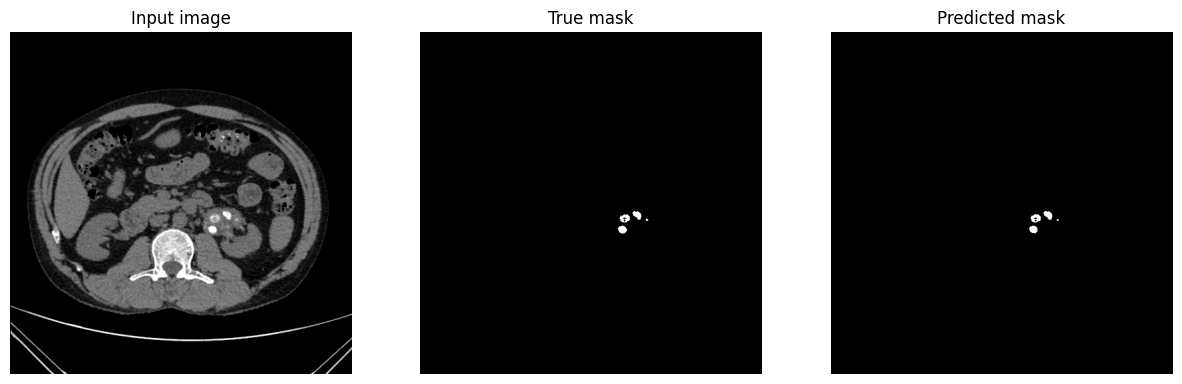

Accuracy: 0.9999198913574219
Jaccard: 0.9442970822281167
Dice: 0.9713506139154161
Precision: 0.978021978021978
Recall: 0.964769647696477


In [17]:
i = random.randint(0, len(X_val))
#i = 155
sample_image = X_val[i]
sample_mask = y_val[i]
prediction = best_model.predict(sample_image[tf.newaxis, ...])[0]
predicted_mask = (prediction > 0.5).astype(np.uint8)
display([sample_image, sample_mask,predicted_mask])

sample_mask = y_val[i].astype(np.uint8).flatten()
predicted_mask = predicted_mask.flatten()


print("Accuracy: "+ str(accuracy_score(sample_mask, predicted_mask)))
print("Jaccard: "+ str(jaccard_score(sample_mask, predicted_mask)))
print("Dice: "+ str((2*jaccard_score(sample_mask, predicted_mask))/(1+jaccard_score(sample_mask, predicted_mask))))
print("Precision: "+ str(precision_score(sample_mask, predicted_mask)))
print("Recall: "+ str(recall_score(sample_mask, predicted_mask)))